In [1]:
import pandas as pd
import numpy as np
import json
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt
import ast  

# Load question

In [4]:
question_path = "../../dataset/questions/WV7_English.jsonl"

In [5]:
question_list = []
with open(question_path, 'r', encoding='utf-8') as f:
    for line in f:
        l = json.loads(line)
        question_list.append(l)

In [6]:
len(question_list)

144

In [8]:
hm_data_path = "../../dataset/wvs/WV7.csv"
hm_df = pd.read_csv(hm_data_path, low_memory=False)

In [10]:
country_path = "../../dataset/country.jsonl"
json_file = open(country_path)
country_dict = json.load(json_file)

In [12]:
country_code_list = [20, 32, 51, 36, 50, 68, 76, 124, 152, 156, 170, 196, 203, 276, 218, 818, 231, 826, 300, 320, 344, 360, 356, 364, 368, 400, 392, 398, 404, 417, 410, 422, 434, 446, 504, 462, 484, 104, 496, 458, 566, 558, 909, 528, 554, 586, 604, 608, 630, 642, 643, 702, 688, 703, 764, 762, 788, 792, 158, 804, 858, 840, 860, 862, 704, 716]
filtered_country_dict = dict()
for country_code in country_code_list:
    country_df = hm_df[hm_df['B_COUNTRY'] == country_code]
    if country_df.empty == False:
        filtered_country_dict[country_code] = country_dict[str(country_code)]

In [13]:
filtered_country_dict['Aya23'] = 'Aya23'
filtered_country_dict['Qwen2.5'] = 'Qwen2.5'
filtered_country_dict['Llama3'] = 'Llama3'
filtered_country_dict['GPT-3.5'] = 'GPT-3.5'
filtered_country_dict['GPT-4'] = 'GPT-4'
filtered_country_dict['DeepSeek-V3'] = 'DeepSeek-V3'
filtered_country_dict['DeepSeek-R1'] = 'DeepSeek-R1'
countries = list(filtered_country_dict.keys())

In [14]:
n_countries = len(countries)

alignment_matrix = np.zeros((n_countries, n_countries))

In [15]:
llm_name_dict = {
    'Aya23': 'CohereLabs/aya-23-35B',
    'Qwen2.5': 'Qwen/Qwen2.5-72B-Instruct',
    'Llama3': 'meta-llama/Meta-Llama-3-70B-Instruct',
    'GPT-3.5': 'gpt-3.5-turbo',
    'GPT-4': 'gpt-4',
    'DeepSeek-V3': 'deepseek-chat',
    'DeepSeek-R1': 'deepseek-reasoner'
}

In [16]:
def load_country_question_probs_list(hm_df, country_code):
    countryquestion_dict = dict()
    country_code = int(country_code)
    country_df = hm_df[hm_df['B_COUNTRY'] == country_code]
    for question in question_list:
        distribution_of_question_dict = dict()
        id = question['id']
        choice_keys = question['choice_keys']
        
        question_df = country_df[id]

        for choice_key in choice_keys:
            choice_count = len(question_df[question_df == int(choice_key)])
            distribution_of_question_dict[choice_key] = choice_count
        if sum(distribution_of_question_dict.values()) == 0:
            continue
        distribution_of_question_dict = [v/sum(distribution_of_question_dict.values()) for k,v in distribution_of_question_dict.items()]
        countryquestion_dict[id] = distribution_of_question_dict
    return countryquestion_dict

In [23]:
def load_llm_question_probs_list(llm_name):
    llm_name = llm_name_dict[llm_name]
    llm_path = f"../../results/RQ1/{llm_name}/results.csv"
    llm_df = pd.read_csv(llm_path)

    question_dict = dict()
    for question in question_list:
        id = question['id']
        choice_keys = question['choice_keys']
        q_df = llm_df[llm_df['id']== id]
        if q_df.empty:
            continue
        response = q_df['response'].values[0]
        probs = ast.literal_eval(response)
        probs = [float(v.strip('%')) / 100 for k, v in probs.items()]
        question_dict[id] = probs
    
    return question_dict


In [20]:
def alignment_score(D1, D2):
    scores = []
    for p1, p2 in zip(D1, D2):
        if len(p1) != len(p2):
            continue
        N = len(p1)
        support = np.arange(1, N + 1)
        wd = wasserstein_distance(support, support, p1, p2)
        score = 1 - wd / (N - 1)
        scores.append(score)
    return np.round(np.mean(scores), 4).item()

In [21]:
def calculate_alignment_score_by_question_list(country_i_question_probs_list, country_j_question_probs_list):
    alignment_score_of_country_i_j = alignment_score(country_i_question_probs_list, country_j_question_probs_list)
    return alignment_score_of_country_i_j

In [24]:
for i, ki in enumerate(countries):
    
    if ki in ['Aya23', 'Qwen2.5', 'Llama3', 'GPT-3.5', 'GPT-4', 'DeepSeek-V3', 'DeepSeek-R1']:
        country_i_question_probs_dict = load_llm_question_probs_list(ki)
    else:
        country_i_question_probs_dict = load_country_question_probs_list(hm_df, ki)
    
    for j, kj in enumerate(countries):
        if kj in ['Aya23', 'Qwen2.5', 'Llama3', 'GPT-3.5', 'GPT-4', 'DeepSeek-V3', 'DeepSeek-R1']:
            country_j_question_probs_dict = load_llm_question_probs_list(kj)
        else:
            country_j_question_probs_dict = load_country_question_probs_list(hm_df, kj)
        
        common_question_ids = set(country_i_question_probs_dict.keys()) & set(country_j_question_probs_dict.keys())
        country_i_question_probs_list = [country_i_question_probs_dict[qid] for qid in common_question_ids]
        country_j_question_probs_list = [country_j_question_probs_dict[qid] for qid in common_question_ids]
        alignment_matrix[i, j] = calculate_alignment_score_by_question_list(
            country_i_question_probs_list,
            country_j_question_probs_list,
        )

# Plot the figure

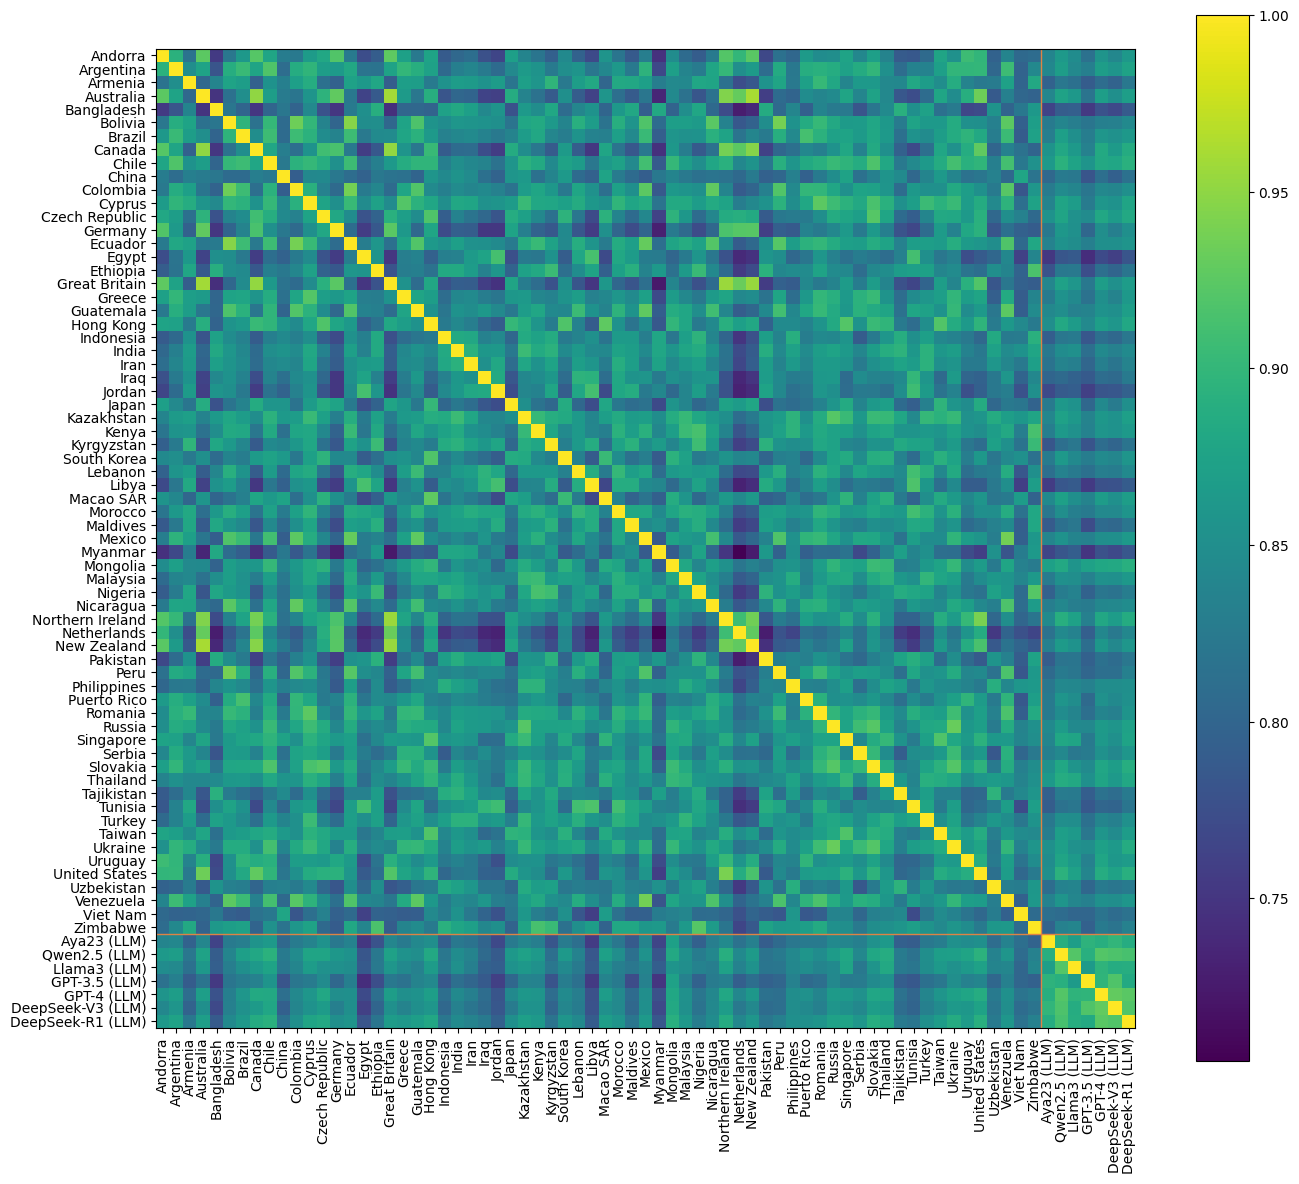

In [34]:
fig, ax = plt.subplots(figsize=(14, 12))
cax = ax.imshow(alignment_matrix)
ax.set_xticks(np.arange(n_countries))
ax.set_yticks(np.arange(n_countries))

country_labels = [filtered_country_dict[k] for k in countries]
for i in country_labels:
    if i in ['Aya23', 'Qwen2.5', 'Llama3', 'GPT-3.5', 'GPT-4', 'DeepSeek-V3', 'DeepSeek-R1']:
        country_labels[country_labels.index(i)] = f'{i} (LLM)'
ax.set_xticklabels(country_labels, rotation=90)
ax.set_yticklabels(country_labels)
line_idx_list = [66]
line_color = '#DE8344'

for line_idx in line_idx_list:
    ax.axhline(line_idx - 0.5, color=line_color, linewidth=1.0)
    ax.axvline(line_idx - 0.5, color=line_color, linewidth=1.0)

fig.colorbar(cax)
plt.tight_layout()
plt.savefig("../../figures/SM/human_performance_all.pdf")

In [27]:
filtered_country_dict

{20: 'Andorra',
 32: 'Argentina',
 51: 'Armenia',
 36: 'Australia',
 50: 'Bangladesh',
 68: 'Bolivia',
 76: 'Brazil',
 124: 'Canada',
 152: 'Chile',
 156: 'China',
 170: 'Colombia',
 196: 'Cyprus',
 203: 'Czech Republic',
 276: 'Germany',
 218: 'Ecuador',
 818: 'Egypt',
 231: 'Ethiopia',
 826: 'Great Britain',
 300: 'Greece',
 320: 'Guatemala',
 344: 'Hong Kong',
 360: 'Indonesia',
 356: 'India',
 364: 'Iran',
 368: 'Iraq',
 400: 'Jordan',
 392: 'Japan',
 398: 'Kazakhstan',
 404: 'Kenya',
 417: 'Kyrgyzstan',
 410: 'South Korea',
 422: 'Lebanon',
 434: 'Libya',
 446: 'Macao SAR',
 504: 'Morocco',
 462: 'Maldives',
 484: 'Mexico',
 104: 'Myanmar',
 496: 'Mongolia',
 458: 'Malaysia',
 566: 'Nigeria',
 558: 'Nicaragua',
 909: 'Northern Ireland',
 528: 'Netherlands',
 554: 'New Zealand',
 586: 'Pakistan',
 604: 'Peru',
 608: 'Philippines',
 630: 'Puerto Rico',
 642: 'Romania',
 643: 'Russia',
 702: 'Singapore',
 688: 'Serbia',
 703: 'Slovakia',
 764: 'Thailand',
 762: 'Tajikistan',
 788: 'T

In [28]:
countries

[20,
 32,
 51,
 36,
 50,
 68,
 76,
 124,
 152,
 156,
 170,
 196,
 203,
 276,
 218,
 818,
 231,
 826,
 300,
 320,
 344,
 360,
 356,
 364,
 368,
 400,
 392,
 398,
 404,
 417,
 410,
 422,
 434,
 446,
 504,
 462,
 484,
 104,
 496,
 458,
 566,
 558,
 909,
 528,
 554,
 586,
 604,
 608,
 630,
 642,
 643,
 702,
 688,
 703,
 764,
 762,
 788,
 792,
 158,
 804,
 858,
 840,
 860,
 862,
 704,
 716,
 'Aya23',
 'Qwen2.5',
 'Llama3',
 'GPT-3.5',
 'GPT-4',
 'DeepSeek-V3',
 'DeepSeek-R1']